In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import keras
from keras.optimizers import Adam
from keras.layers import Input, GRU, Flatten, MaxPool2D, MaxPool1D
from keras.layers import PReLU, Dropout, Lambda, Dense
from keras.models import Model
import tensorflow as tf

from music_generator.basic.random import generate_dataset
from music_generator.basic.signalproc import SamplingInfo
from music_generator.musical.timing import Tempo
from music_generator.musical.scales import GenericScale
from music_generator.analysis.play import play_mono_as_stereo, play_array
from music_generator.basic.signalproc import mix_at
from music_generator.analysis import preprocessing

from music_generator.musical import scales
import numpy as np
from multiprocessing import Pool
from functools import partial

import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline
import matplotlib

from scipy.io.wavfile import read

/home/marcelra/Pycharmprojects/music-generator/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)

In [4]:
sr, full_mix = read("../data/full-mix.wav", mmap=False)
sr, only_guitar = read("../data/only-guitar.wav", mmap=False)

full_mix = full_mix.astype(np.float) / 2**15
only_guitar = only_guitar.astype(np.float) / 2**15

/home/marcelra/Pycharmprojects/music-generator/venv/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [5]:
# import plotly
# import plotly.graph_objs as go
# from plotly.offline import iplot

# plotly.offline.init_notebook_mode(connected=True)

In [6]:
import pandas as pd

In [7]:
df = pd.DataFrame({'guitar': only_guitar}, index=np.arange(len(only_guitar))/ 44100)
df['full_mix'] = full_mix
df['rolling_mse'] = df['guitar'].rolling(window=2000, center=False).std()

In [8]:
df['is_playing'] = df['rolling_mse'] > 0.1
df['is_playing_float'] = df['is_playing'] * 1.0

In [9]:
df['signal_masked'] = df['is_playing'] * df['guitar']

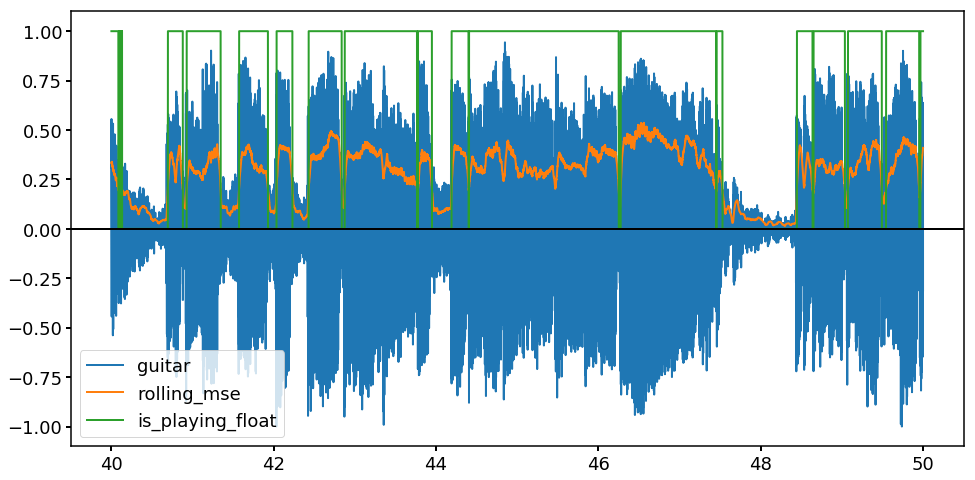

In [10]:
t0 = 40
delta = 10
df.loc[t0:t0+delta][['guitar', 'rolling_mse', 'is_playing_float']].plot()
plt.axhline(y=0, color='k')

In [11]:
play_array(df['signal_masked'].values, range_secs=[20,30])

## Make data set

In [73]:
def create_random_fragment_indices(n_batches, n_samples, fragment_length):
    i_max = n_samples - fragment_length
    start = np.random.randint(low=0, high=i_max, size=n_batches)
    
    return np.array([np.arange(s, s+fragment_length) for s in start])

In [74]:
x_train = df['full_mix'].values
y_train = df['is_playing'].values

fragment_length = 4096
n_fragments = 20000

ind = create_random_fragment_indices(n_fragments, len(x_train), fragment_length)

In [75]:
x_train = x_train[ind]
y_train = y_train[ind]

In [76]:
x_train = x_train.reshape(-1, fragment_length)
y_train = y_train.reshape(-1, fragment_length)

y_train = np.percentile(y_train, q=80, axis=1).reshape(-1, 1)

In [77]:
import tensorflow as tf

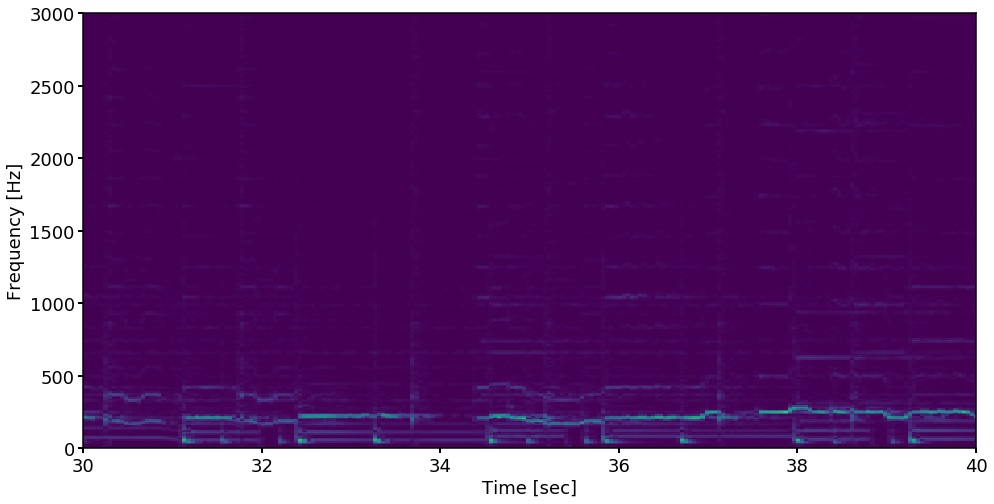

In [78]:
from scipy.signal import stft
f_vec, t_vec, Zxx = stft(full_mix, sr, nperseg=4096)
plt.pcolormesh(t_vec, f_vec, np.abs(Zxx), vmin=0, vmax=0.5)
# plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 3000)
plt.xlim(30, 40);

In [79]:
inp = Input(shape=[fragment_length])
out = inp

def apply_fft(tensor):
    tensor = tf.cast(tensor, tf.complex64)
    return tf.abs(tf.spectral.fft(tensor))

out = Lambda(apply_fft, output_shape=[fragment_length])(out)
out = Dense(units=1, activation='sigmoid')(out)

model = Model(inp, out)
model.summary()
model.compile(Adam(lr=1e-3), 'binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 4096)              0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 4096)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 4097      
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 9s 573us/step - loss: 1.3446 - acc: 0.8013 - val_loss: 1.3310 - val_acc: 0.7837
Epoch 2/10
16000/16000 [==============================] - 9s 565us/step - loss: 0.6994 - acc: 0.8567 - val_loss: 0.5357 - val_acc: 0.8792
Epoch 3/10
16000/16000 [==============================] - 9s 563us/step - loss: 0.5617 - acc: 0.8739 - val_loss: 0.4919 - val_acc: 0.8780
Epoch 4/10
16000/16000 [==============================] - 9s 566us/step - loss: 0.4909 - acc: 0.8779 - val_loss: 0.4227 - val_acc: 0.8945
Epoch 5/10
16000/16000 [==============================] - 9s 564us/step - loss: 0.4722 - acc: 0.8854 - val_loss: 0.3973 - val_acc: 0.8872
Epoch 6/10
16000/16000 [==============================] - 9s 566us/step - loss: 0.4474 - acc: 0.8872 - val_loss: 0.4573 - val_acc: 0.8885
Epoch 7/10
16000/16000 [==============================] - 9s 565us/step - loss: 0.4957 - acc: 0.8829 - val_loss: 0.5015 - v

In [89]:
# def predict(vals):
# #     vals = vals.values
#     return model.predict(vals.reshape([1, len(vals)]))

In [88]:
y_pred = model.predict(x_train)

In [93]:
x_train.reshape(-1)
y_pred.reshape(-1)

array([9.1057147e-05, 9.9980706e-01, 1.3554750e-01, ..., 3.4782029e-04,
       9.9993992e-01, 9.9999988e-01], dtype=float32)